# anime art tagger

this is a showcase of the model used, training results and *unsupervised* inference for a tiny sample.

In [1]:
import numpy as np
import pandas as pd
import altair as alt

from pathlib import Path
from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import transforms as T
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

from torchinfo import summary

In [2]:
!python --version

for package in [np, pd, alt, torch, torchvision]:
    print(package.__name__, package.__version__)

Python 3.9.13
numpy 1.21.5
pandas 1.4.3
altair 4.2.0
torch 1.12.1
torchvision 0.13.1


In [3]:
dev = torch.device(('cpu', 'cuda')[torch.cuda.is_available()])

## tag data

See `data/dataprep.py` for full process, including image extraction.

In [4]:
data_path = Path('data')

In [5]:
label_converter = pd.read_csv(
    data_path/'top_tags.csv').squeeze()
print(label_converter.to_string())

0                         long_hair
1                 looking_at_viewer
2                             smile
3                             blush
4                        short_hair
5                        open_mouth
6                             skirt
7                             bangs
8                 simple_background
9                         blue_eyes
10                 white_background
11    eyebrows_visible_through_hair
12                            dress
13                    hair_ornament
14                      blonde_hair
15                       thighhighs
16                         red_eyes
17                       brown_hair
18                           ribbon
19                    large_breasts
20                           gloves
21                              hat
22                     long_sleeves
23                              bow
24                            shirt
25                         cleavage
26                   very_long_hair
27                   bare_sh

## the model

Mashed the two resnet50-based models by [RF5](https://github.com/RF5/danbooru-pretrained) and [anthony](https://github.com/anthony-dipofi/danbooru-tagger) and replaced the base with efficientnetv2s.

### defs

In [6]:
def bn_drop_lin(in_size, out_size):
    return nn.Sequential(
        nn.BatchNorm1d(
            in_size,
            eps=1e-05,
            momentum=0.1,
            affine=True,
            track_running_stats=True),
        nn.Dropout(p=0.25, inplace=False),
        nn.Linear(in_size, out_size))

In [7]:
class Tagger(nn.Module):
    def __init__(self):
        super(Tagger, self).__init__()

        self.out_classes = len(label_converter)

        backbone = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
        layers = list(backbone.children())
        in_features = layers[-1][-1].in_features
        self.base = nn.Sequential(*layers[:-1]).eval()

        self.classifier = bn_drop_lin(in_features, self.out_classes)

    def forward(self, t_in):

        t_base = F.leaky_relu(self.base(t_in))[:, :, 0, 0]
        
        t = F.leaky_relu(self.classifier(t_base))
        
        t_rs = t.reshape([len(t_base), self.out_classes])
        t_cl = torch.clamp(t_rs, -10, 10)

        t_out = torch.sigmoid(t_cl)

        return t_out

### instantiate model

In [8]:
torch.hub.set_dir('C:/Dev/.cache/pytorch')
model = Tagger().to(dev)

state_dict = Path('model') / 'results' / 'model_state_dict.pt'
model.load_state_dict(torch.load(state_dict, map_location=dev))

<All keys matched successfully>

### model summary

an illustration of the model during training

In [9]:
for param in model.base.parameters():
    param.requires_grad = False

batch_size = 128
channels = 3
height = width = 384

summary(model, input_size=(
        batch_size, channels, height, width))

Layer (type:depth-idx)                                       Output Shape              Param #
Tagger                                                       [128, 56]                 --
├─Sequential: 1-1                                            [128, 1280, 1, 1]         --
│    └─Sequential: 2-1                                       [128, 1280, 12, 12]       --
│    │    └─Conv2dNormActivation: 3-1                        [128, 24, 192, 192]       (696)
│    │    └─Sequential: 3-2                                  [128, 24, 192, 192]       (10,464)
│    │    └─Sequential: 3-3                                  [128, 48, 96, 96]         (303,552)
│    │    └─Sequential: 3-4                                  [128, 64, 48, 48]         (589,184)
│    │    └─Sequential: 3-5                                  [128, 128, 24, 24]        (917,680)
│    │    └─Sequential: 3-6                                  [128, 160, 24, 24]        (3,463,840)
│    │    └─Sequential: 3-7                             

## training results

MSE Loss over epochs for training set (\~7K images) and validation set (867 images).  
see `model/train_nn.ipynb` for full process.

![](model/results/losses.png)

inference results for a **new** dataset of 867 test images:
- classification metrics for different probability thresholds above which a tag is used for an image.
- a confusion matrix and metrics for the selected threshold (35%).

see `model/test_nn.ipynb` for full process.

![](model/results/thresh.png)

![](model/results/conf.png)

## unsupervised inference

a sample of 4 images to apply the model on. they weren't cherrypicked for the best results, i just like the characters.

In [10]:
def load_image(path):

    img = T.Resize(384)(Image.open(path).convert('RGB'))

    display(img)

    return T.Compose([
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])(img).unsqueeze(0)

In [11]:
def proba2lbls(proba, thresh):
    conv = pd.DataFrame(
        label_converter
    ).assign(
        proba=pd.Series(proba),
    ).sort_values(
        'proba', ascending=False
    ).reset_index(drop=True)
    
    res = conv[conv.proba>thresh].copy()
    res.proba = res.proba.apply(lambda num: f'{num:.1%}')
    return res

chika


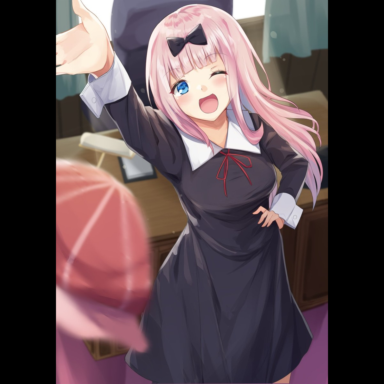

,tag,proba
0,looking_at_viewer,100.0%
1,blush,49.0%
2,bangs,48.3%
3,eyebrows_visible_through_hair,46.8%
4,smile,46.1%
5,open_mouth,41.9%
6,long_hair,41.8%
7,skirt,41.1%
8,shirt,39.1%
9,short_hair,37.1%




kokkoro


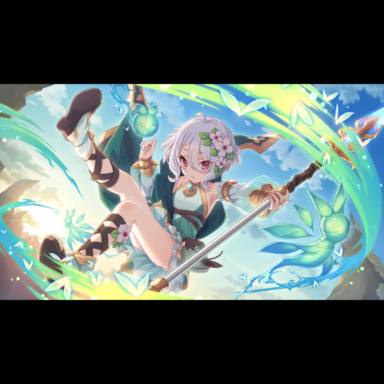

,tag,proba
0,looking_at_viewer,93.5%
1,smile,47.7%
2,holding,47.5%
3,hair_ornament,47.0%
4,dress,42.9%
5,ribbon,42.8%
6,long_hair,40.4%
7,blush,39.7%
8,open_mouth,39.1%
9,blonde_hair,38.3%




kyouko


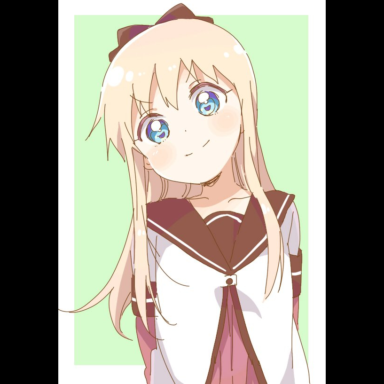

,tag,proba
0,blonde_hair,100.0%
1,long_hair,98.6%
2,looking_at_viewer,49.1%
3,blush,46.2%
4,bangs,43.6%
5,smile,43.2%
6,simple_background,43.0%
7,eyebrows_visible_through_hair,40.9%
8,white_background,37.9%




marin


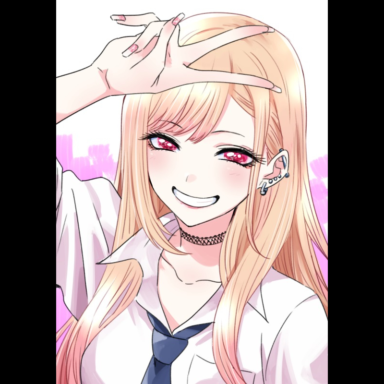

,tag,proba
0,blush,100.0%
1,long_hair,99.9%
2,open_mouth,49.3%
3,smile,48.1%
4,bangs,47.3%
5,looking_at_viewer,45.7%
6,bow,44.4%
7,eyebrows_visible_through_hair,42.7%
8,long_sleeves,39.0%
9,simple_background,37.4%


In [12]:
model.eval()
thresh = .35

for fp in Path('sample-images').rglob('*'):
    
    print(fp.stem)
    
    input_tensor = load_image(fp)
    output_tensor = model(input_tensor).detach().squeeze()
    
    display(proba2lbls(output_tensor, thresh))

    print('\n==============\n')